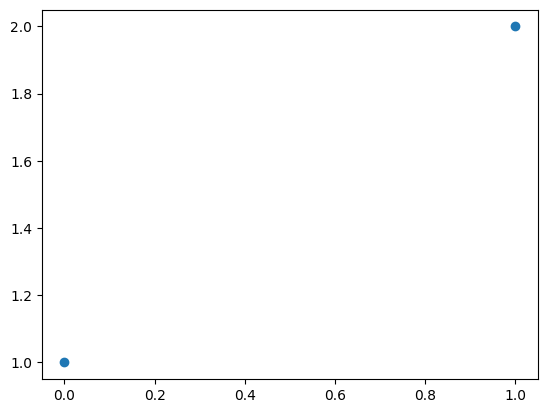

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
importlib.reload(kgs)
importlib.reload(seis_test)
importlib.reload(seis_forward)
#seis_test.run_all_tests(test_reference_mode=True)


<module 'seis_forward' from 'f:\\seismic/code/core\\seis_forward.py'>

In [3]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [22]:
from seis_forward import *
import seis_numerics
importlib.reload(seis_numerics)
@kgs.profile_each_line
def vel_to_seis_ref_dev(vec, vec_diff, vec_adjoint):
    assert vec.shape == (4901,1)
    #assert adjoint_vec.shape == (5*999*70,1)
    assert vec_diff.shape == (4901,1)
    v=cp.reshape(vec[:-1,0], (70,70))
    min_vel = vec[-1,0]
    
    v = cp.pad(v, ((nbc, nbc), (nbc, nbc)), mode='edge')
    abc = min_vel*damp
    v2 = v**2

    alpha = v2* (dt / dx)**2
    kappa = abc * dt
    temp1 = 2 + 2 * c1 * alpha - kappa
    temp2 = 1 - kappa

    #result = cp.concatenate((alpha.flatten(),temp1.flatten(),temp2.flatten()))[:,None]

    seis_combined = cp.zeros((5,999,70),dtype=kgs.base_type_gpu)
    p_complete_list = []

    for i_source in range(5):    #XXX    
        src_idx = src_idx_list[i_source]
        bdt = (cp.asnumpy(v[isz_list[i_source], isx_list[i_source]])*dt)**2
        s_mod = bdt*s

        p_complete = cp.zeros((nt+2,temp1.shape[0],temp1.shape[1]), dtype=kgs.base_type_gpu)
        lapg_store = cp.zeros_like(p_complete)
        
        for it in range(0, nt):

            p1 = p_complete[it+1,...]
            p0 = p_complete[it,...]
            lapg_store[it+2,...] = (cp.array(c2) * (cp.roll(p1, 1, axis=1) + cp.roll(p1, -1, axis=1) +
                           cp.roll(p1, 1, axis=0) + cp.roll(p1, -1, axis=0)) +
                     cp.array(c3) * (cp.roll(p1, 2, axis=1) + cp.roll(p1, -2, axis=1) +
                           cp.roll(p1, 2, axis=0) + cp.roll(p1, -2, axis=0)))
            p_complete[it+2,...] = (temp1 * p1 - temp2 * p0 +
                 alpha * lapg_store[it+2,...])
            #p_complete[it+2,...] = i_source*it*temp1+temp2+alpha
            p_complete[it+2,...].ravel()[src_idx] += s_mod[it]   

        seis_combined[i_source,...] = p_complete[2:,igz,igx]
        p_complete_list.append((cp.asnumpy(p_complete), cp.asnumpy(lapg_store)))

    assert seis_combined.shape == (5,999,70)
    result =  seis_combined.flatten()[:,None]

    # DIFF

    v_diff=cp.reshape(vec_diff[:-1,0], (70,70))
    min_vel_diff = vec_diff[-1,0]
    
    v_diff = cp.pad(v_diff, ((nbc, nbc), (nbc, nbc)), mode='edge')
    abc_diff = min_vel_diff*damp
    v2_diff = 2*v*v_diff

    alpha_diff = v2_diff* (dt / dx)**2
    kappa_diff = abc_diff * dt
    temp1_diff = 2 * c1 * alpha_diff - kappa_diff
    temp2_diff = -kappa_diff

    #result_diff = cp.concatenate((alpha_diff.flatten(),temp1_diff.flatten(),temp2_diff.flatten()))[:,None]

    seis_combined_diff = cp.zeros((5,999,70),dtype=kgs.base_type_gpu)
    for i_source in range(5):
        src_idx = src_idx_list[i_source]
        bdt_diff = 2*((cp.asnumpy(v[isz_list[i_source], isx_list[i_source]]*v_diff[isz_list[i_source], isx_list[i_source]])))* dt**2
        s_mod_diff = bdt_diff*s
        
        (p_complete, lapg_store) = p_complete_list[i_source]
        p_complete = cp.array(p_complete)
        lapg_store = cp.array(lapg_store)
        p_complete_diff = cp.zeros((nt+2,temp1.shape[0],temp1.shape[1]), dtype=kgs.base_type_gpu)

        for it in range(0, nt):
            p1_diff = p_complete_diff[it+1,...]
            p0_diff = p_complete_diff[it,...]
            p1 = p_complete[it+1,...]
            p0 = p_complete[it,...]
            lapg_store_diff = (cp.array(c2) * (cp.roll(p1_diff, 1, axis=1) + cp.roll(p1_diff, -1, axis=1) +
                           cp.roll(p1_diff, 1, axis=0) + cp.roll(p1_diff, -1, axis=0)) +
                     cp.array(c3) * (cp.roll(p1_diff, 2, axis=1) + cp.roll(p1_diff, -2, axis=1) +
                           cp.roll(p1_diff, 2, axis=0) + cp.roll(p1_diff, -2, axis=0)))
            p_complete_diff[it+2,...] = (temp1 * p1_diff + temp1_diff*p1 - temp2_diff * p0 - temp2*p0_diff + 
                 alpha_diff * lapg_store[it+2,...] + alpha*lapg_store_diff)
            #p_complete_diff[it+2,...] = i_source*it*temp1_diff+temp2_diff+alpha_diff
            p_complete_diff[it+2,...].ravel()[src_idx] += s_mod_diff[it]   

        seis_combined_diff[i_source,...] = p_complete_diff[2:,igz,igx]

    assert seis_combined_diff.shape == (5,999,70)
    result_diff =  seis_combined_diff.flatten()[:,None]

        

    # ADJOINT

    seis_combined_adjoint = cp.reshape(vec_adjoint, (5,999,70))
    alpha_adjoint = cp.zeros_like(alpha)
    temp1_adjoint = cp.zeros_like(alpha)
    temp2_adjoint = cp.zeros_like(alpha)
    v_adjoint = cp.zeros_like(v)
    for i_source in range(5):
        src_idx = src_idx_list[i_source]
        
        (p_complete, lapg_store) = p_complete_list[i_source]
        p_complete = cp.array(p_complete)
        lapg_store = cp.array(lapg_store)

        p_complete_adjoint =  cp.zeros((nt+2,temp1.shape[0],temp1.shape[1]), dtype=kgs.base_type_gpu)
        p_complete_adjoint[2:,igz,igx] = seis_combined_adjoint[i_source,...]

        s_mod_adjoint = cp.zeros_like(s_mod)
        for it in np.arange(nt-1,-1,-1):
            s_mod_adjoint[it] = p_complete_adjoint[it+2,...].ravel()[src_idx]
            p_complete_adjoint[it+1,...] += temp1 * p_complete_adjoint[it+2,...]
            temp1_adjoint+=p_complete[it+1,...] * p_complete_adjoint[it+2,...]
            p_complete_adjoint[it,...] -= temp2 * p_complete_adjoint[it+2,...]
            temp2_adjoint-=p_complete[it,...] * p_complete_adjoint[it+2,...]
            alpha_adjoint+=lapg_store[it+2,...] * p_complete_adjoint[it+2,...]
            lapg_store_adjoint = alpha*p_complete_adjoint[it+2,...]
            p1_adjoint = (cp.array(c2) * (cp.roll(lapg_store_adjoint, -1, axis=1) + cp.roll(lapg_store_adjoint, 1, axis=1) +
                              cp.roll(lapg_store_adjoint, -1, axis=0) + cp.roll(lapg_store_adjoint, 1, axis=0)) +
              cp.array(c3) * (cp.roll(lapg_store_adjoint, -2, axis=1) + cp.roll(lapg_store_adjoint, 2, axis=1) +
                              cp.roll(lapg_store_adjoint, -2, axis=0) + cp.roll(lapg_store_adjoint, 2, axis=0)))
            p_complete_adjoint[it+1,...]+= p1_adjoint
            

        bdt_adjoint = cp.sum(s_mod_adjoint*cp.array(s))
        v_adjoint[isz_list[i_source], isx_list[i_source]] += 2*dt**2 * v[isz_list[i_source], isx_list[i_source]] * bdt_adjoint
        
        
    
    # N = vec_adjoint.shape[0]   
    # alpha_adjoint = cp.reshape(vec_adjoint[:N//3,0], temp2_diff.shape)
    # temp1_adjoint = cp.reshape(vec_adjoint[N//3:2*N//3,0], temp2_diff.shape)
    # temp2_adjoint = cp.reshape(vec_adjoint[2*N//3:,0], temp2_diff.shape)
    #temp1_adjoint = 
    kappa_adjoint = -temp2_adjoint
    alpha_adjoint += 2 * c1 * temp1_adjoint
    kappa_adjoint += -temp1_adjoint
    abc_adjoint = kappa_adjoint * dt
    v2_adjoint = alpha_adjoint * (dt/dx)**2

    v_adjoint += 2*v*v2_adjoint
    min_vel_adjoint = cp.sum(abc_adjoint*damp)
    v_adjoint = seis_numerics.unpad_edge_padded_gradient(v_adjoint,nbc)#v_adjoint[nbc:-nbc,nbc:-nbc]

    result_adjoint = cp.zeros(vec.shape)
    result_adjoint[-1,0] = min_vel_adjoint
    result_adjoint[:-1,0] = v_adjoint.flatten()


    return result, result_diff, result_adjoint

    return

    seis_combined = cp.empty((5,999,70),dtype=kgs.base_type_gpu)

    for i_source in range(2):        
        src_idx = src_idx_list[i_source]
        bdt = (cp.asnumpy(v[isz_list[i_source], isx_list[i_source]])*dt)**2
        s_mod = bdt*s

        p_complete = cp.zeros((nt+2,temp1.shape[0],temp1.shape[1]), dtype=kgs.base_type_gpu)
        
        for it in range(0, nt):

            p1 = p_complete[it+1,...]
            p0 = p_complete[it,...]
            lapg_store = (cp.array(c2) * (cp.roll(p1, 1, axis=1) + cp.roll(p1, -1, axis=1) +
                           cp.roll(p1, 1, axis=0) + cp.roll(p1, -1, axis=0)) +
                     cp.array(c3) * (cp.roll(p1, 2, axis=1) + cp.roll(p1, -2, axis=1) +
                           cp.roll(p1, 2, axis=0) + cp.roll(p1, -2, axis=0)))
            p_complete[it+2,...] = (temp1 * p1 - temp2 * p0 +
                 alpha * lapg_store)
            p_complete[it+2,...].ravel()[src_idx] += s_mod[it]   

        seis_combined[i_source,...] = p_complete[2:,igz,igx]

    seis_combined = cp.stack(seis_combined)
    assert seis_combined.shape == (5,999,70)
    results =  seis_combined.flatten()[:,None]

    # Now create code to generate results_adjoint, such that:
    # results_adjoint == J.T * adjoint_vec
    # With J the Jacobian of vel_to_seis_ref at location vec

    return results

In [ ]:
import cupy as cp

d = kgs.load_all_train_data()[0]
d.load_to_memory()    
vec = d.velocity.to_vector()
r= np.random.default_rng(seed=0)
vec_diff = cp.asarray(1e-2*r.normal(0,1,vec.shape))
#vec_diff[:-1,0]=0
vec_adjoint = cp.asarray(1e-2*r.normal(0,1,(349650,1)))
vec_adjoint[vec_adjoint.shape[0]//3:2*vec_adjoint.shape[0]//3]=0

kgs.profiling=True
result, result_diff, result_adjoint = vel_to_seis_ref_dev(vec, vec_diff, vec_adjoint)
kgs.profiling=False
print(result.shape)

print(kgs.rms(result - seis_forward.vel_to_seis_ref(vec)))

res1 = cp.sum(vec_adjoint*result_diff)
res2 = cp.sum(result_adjoint*vec_diff)

print('adjoint', cp.abs(res1-res2), res1)

result_offset = vel_to_seis_ref_dev(vec+vec_diff, vec_diff, vec_adjoint)[0]

print(kgs.rms(result_offset-result-result_diff), kgs.rms(result_offset-result))



In [6]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [7]:
np.arange(0,5)

array([0, 1, 2, 3, 4])

In [8]:
np.arange(4,-1,-1)

array([4, 3, 2, 1, 0])